## 时序差分预测

### 随机游走
### Example 6.2 with Exercises 6.3-6.6 and two graphs

s: A-E 这里用1-5替代 左右两个终止态分别为0 6 

a: 向左 向右

r: 到最右边的终止态+1 其他均为0

env: 外部文件gridworld.py已经写好环境

In [1]:
import numpy as np
import random
from gridworld import RandomWalk
from tqdm import tqdm


import matplotlib
import matplotlib.pyplot as plt
#matplotlib.style.use('ggplot')
matplotlib.use('Agg')

%matplotlib inline

In [2]:
env = RandomWalk()  #环境
env.action_space.sample() #policy： 向左 向右 均匀概率采样

0

In [3]:
TRUE_VALUE = np.zeros(7)
TRUE_VALUE[1:6] = np.arange(1, 6) / 6.0
TRUE_VALUE[6] = 1   
print(TRUE_VALUE) #手动求解MRP得到的真实值

[0.         0.16666667 0.33333333 0.5        0.66666667 0.83333333
 1.        ]


In [4]:
VALUES = np.ones(7)*0.5 #初始化近似价值函数 0，0.5...0.5,1
VALUES[0] = 0
VALUES[6] = 1
print(VALUES)

[0.  0.5 0.5 0.5 0.5 0.5 1. ]


In [12]:
def temporal_difference(env, V, alpha=0.1, discount_factor=1.0, batch=False): #alpha步长
    s = env.reset() #从中间开始
    trajectory = [s]
    rewards = [0]
    while True:
        a = env.action_space.sample() #policy： 向左 向右 均匀概率采样
        s_, r, done, info =  env.step(a)
        r = 0  #不明白为什么 只有假设所有的reward=0 才能复现书上的结果。。。
        trajectory.append(s_)
        if not batch:
            V[s] += alpha * (r + discount_factor * V[s_] - V[s] )
            
        if done:
            break
        rewards.append(r)
        s = s_  
    return trajectory, rewards


In [13]:
def monte_carlo(env, V, alpha=0.1, batch=False):
    s = env.reset()
    trajectory = [s]
    while True:
        a = env.action_space.sample() 
        s_, r, done, info = env.step(a)
        trajectory.append(s_)
        if done:
            G = r #每个epsido结束之后的最终rewar作为累积回报G
            break
            
    if not batch:
        for s in trajectory[:-1]: #终止态不进入计算
            #MC update
            V[s] += alpha * (G - V[s])
    return trajectory, [G] * (len(trajectory)-1)
        

In [14]:
def compute_state_value():
    env = RandomWalk()
    episodes = [0, 1, 10, 100]

    current_values = np.copy(VALUES)
    plt.figure(1)
    for i in range(episodes[-1] + 1):
        if i in episodes:
            plt.plot(current_values, label=str(i) + ' episodes')
        temporal_difference(env, current_values)
    plt.plot(TRUE_VALUE, label='true values')
    plt.xlabel('state')
    plt.ylabel('estimated value')
    plt.legend()


In [15]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

In [16]:
def rms_error():
    # Same alpha value can appear in both arrays
    td_alphas = [0.15, 0.1, 0.05]
    mc_alphas = [0.01, 0.02, 0.03, 0.04]
    episodes = 100 + 1
    runs = 100
    for i, alpha in enumerate(td_alphas + mc_alphas):
        total_errors = np.zeros(episodes)
        if i < len(td_alphas):
            method = 'TD'
            linestyle = 'solid'
        else:
            method = 'MC'
            linestyle = 'dashdot'
        for r in tqdm(range(runs)):
            errors = []
            current_values = np.copy(VALUES)
            for i in range(0, episodes):
                #errors.append(np.sqrt(np.sum(np.power(TRUE_VALUE - current_values, 2)) / 5.0))
                errors.append(rmse(current_values, TRUE_VALUE))
                if method == 'TD':
                    temporal_difference(env, current_values, alpha=alpha)
                else:
                    monte_carlo(env, current_values, alpha=alpha)
            total_errors += np.asarray(errors)
        total_errors /= runs
        plt.plot(total_errors, linestyle=linestyle, label=method + ', alpha = %.02f' % (alpha))
    plt.xlabel('episodes')
    plt.ylabel('RMS')
    plt.legend()

100%|██████████| 100/100 [00:00<00:00, 163.46it/s]


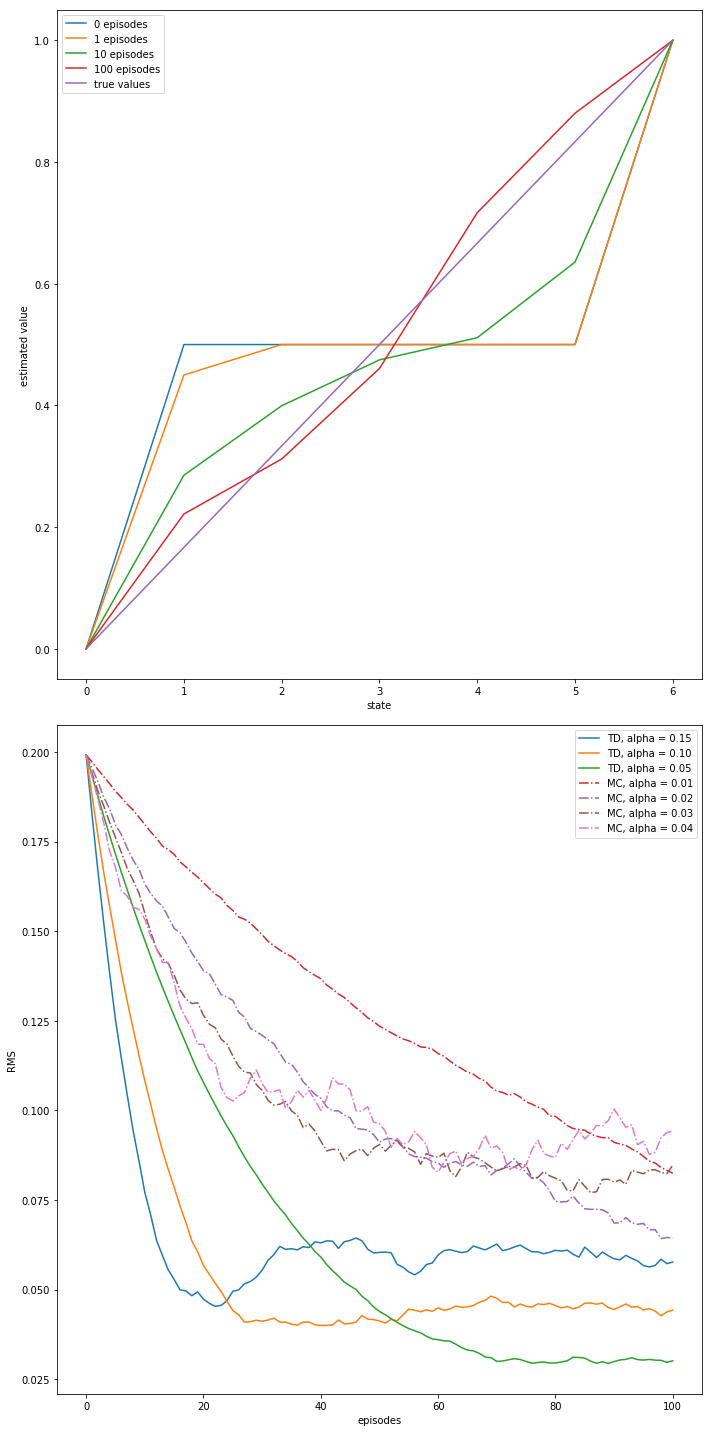

In [18]:
plt.figure(figsize=(10, 20))
plt.subplot(2, 1, 1)
compute_state_value()

plt.subplot(2, 1, 2)
rms_error()
plt.tight_layout()

plt.show()

#plt.savefig('./images/example_6_2.png')
#plt.close()

In [19]:
plt.figure(figsize=(10, 20))
plt.subplot(2, 1, 1)
compute_state_value()

plt.subplot(2, 1, 2)
rms_error()
plt.tight_layout()

#plt.show()

plt.savefig('./images/example_6_2.png')
plt.close()

100%|██████████| 100/100 [00:00<00:00, 163.81it/s]
